<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Mini

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-03 21:13:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-03 21:13:14 (71.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Import modules and packages

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
def compare_historys(original_history, new_history, initial_epochs=5):

  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([5-1, 5-1], plt.ylim(), label="Start fine tunning")
  plt.legend(loc="lower right")
  plt.title("Training and validation accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Val loss")
  plt.plot([5-1, 5-1], plt.ylim(), label="Start fine tunning")
  plt.legend(loc="upper right")
  plt.title("Training and validation loss")


## Get the data

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")
walk_through_dir("101_food_classes_10_percent")

--2024-03-03 21:13:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   125MB/s    in 9.5s    

2024-03-03 21:13:44 (163 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories a

In [8]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

train_data =  tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  image_size=IMAGE_SIZE,
                                                                  batch_size=BATCH_SIZE,
                                                                  label_mode="categorical",
                                                               )

test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  image_size=IMAGE_SIZE,
                                                                  batch_size=BATCH_SIZE,
                                                                  label_mode="categorical",
                                                                  shuffle=False) # Don't shuffle test data for predictions



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Visualize the images

Text(0.5, 1.0, 'Original Image')

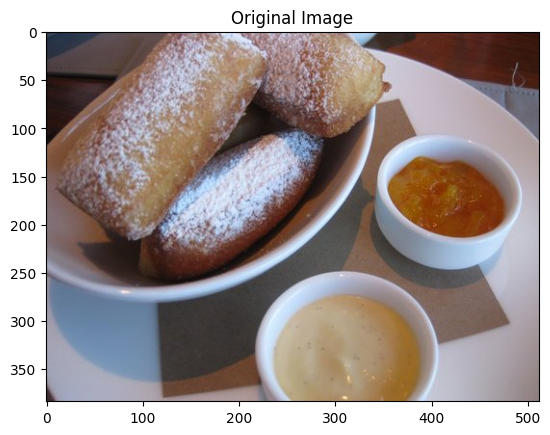

In [11]:
target_class = random.choice(train_data.class_names)
target_dir = "101_food_classes_10_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("Original Image")

## Model 0 - 10% data of 101 classes of images

1. Create Model checkpoint
2. Create data augmentation layer
3. Build headless (no top layer) functional efficientnetb0 backboned moded.
4. Compile the mode
5. Feature extractor for 5 full passes (5 epochs on 15% of validation data)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup checkpointing
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)
# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

number_of_classes = len(train_data.class_names)

# Create feature extractor model (Not-fine tunned) using efficient net as a base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input_layer = layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = data_augmentation(input_layer)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
output_layer = layers.Dense(number_of_classes, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(input_layer, output_layer)

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the mode
history_model_0 = model_0.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_per_data_aug"),
                                         checkpoint_callback])

# Evaluate the model on full test data
model_0.evaluate(test_data)

# Plot the training curves
plot_loss_curves(history_model_0)

Saving TensorBoard log files to: transfer_learning/1_per_data_aug/20240303-211950
Epoch 1/5
237/237 [==============================] - 853s 4s/step - loss: 3.5154 - accuracy: 0.2407 - val_loss: 2.7483 - val_accuracy: 0.3748
Epoch 2/5
106/237 [============>.................] - ETA: 6:44 - loss: 2.5244 - accuracy: 0.4419

## Fine Tunning

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False


# Recompile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Print which layers are trainable
for layer in base_model.layers:
  print(layer.name, layer.trainable)

history_model_2 = model_0.fit(train_data,
                              epochs=10,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[ checkpoint_callback])

# Evaluate the model on full test data
model_0.evaluate(test_data)

# Plot the training curves
plot_loss_curves(history_model_2)